# Last Millennium Reanalysis with PAGES2k

In this section, we illustrate performing a Last Millennium Reanalysis (LMR) flow assimilating the PAGES2k database with `cfr`.

Required data to complete this tutorial:

- iCESM simulated air surface temperature: [tas_sfc_Amon_iCESM_past1000historical_085001-200512.nc](https://atmos.washington.edu/~rtardif/LMR/prior/tas_sfc_Amon_iCESM_past1000historical_085001-200512.nc)
- iCESM simulated precipitation rate: [pr_sfc_Amon_iCESM_past1000historical_085001-200512.nc](https://atmos.washington.edu/~rtardif/LMR/prior/pr_sfc_Amon_iCESM_past1000historical_085001-200512.nc)
- PAGES2k database: [pages2k_updated_Palmyra_dataset.pkl](./data/pages2k_updated_Palmyra_dataset.pkl)
- [20CR v3](https://psl.noaa.gov/data/gridded/data.20thC_ReanV3.html)
  - Cite: NOAA/CIRES/DOE 20th Century Reanalysis (V3) data provided by the NOAA PSL, Boulder, Colorado, USA, from their website at https://psl.noaa.gov 
  - Paper: https://rmets.onlinelibrary.wiley.com/doi/10.1002/qj.3598
  - tas: [air.2m.mon.mean.nc](https://downloads.psl.noaa.gov/Datasets/20thC_ReanV3/Monthlies/2mSI-MO/air.2m.mon.mean.nc)
  - pr: [prate.mon.mean.nc](https://downloads.psl.noaa.gov/Datasets/20thC_ReanV3/Monthlies/sfcSI-MO/prate.mon.mean.nc)

In [1]:
%load_ext autoreload
%autoreload 2

import cfr
import pandas as pd
import numpy as np

## Load and filter the PAGES2k database

>>> job.configs["slice_proxydb_timespan"] = (1000, 2000)


Slicing ProxyRecord: 100%|██████████| 592/592 [00:03<00:00, 163.32it/s]


>>> job.proxydb updated


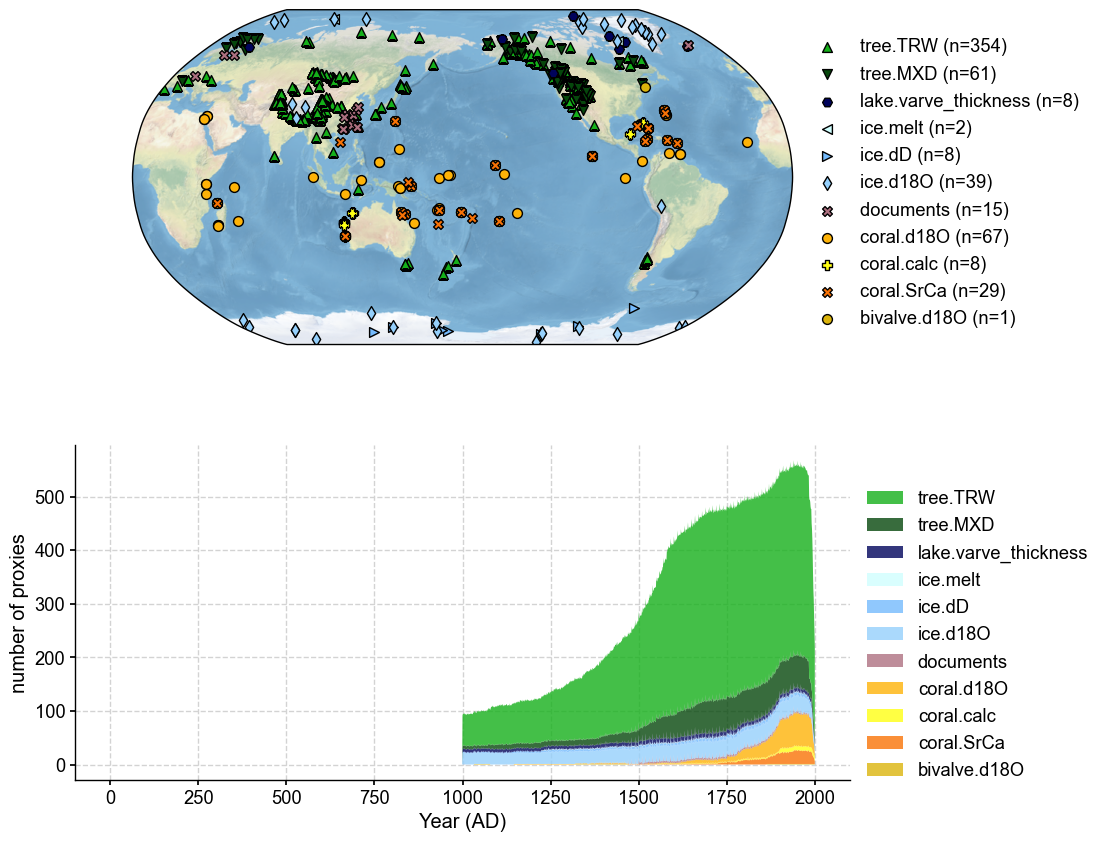

In [2]:
job = cfr.ReconJob()
job.load_proxydb('./data/pages2k_updated_Palmyra_dataset.pkl')
job.filter_proxydb(by='ptype', keys=[
    'coral',
    'ice',
    'bivalve',
    'lake.varve_thickness',
    'tree',
    'documents',
])
job.slice_proxydb(timespan=(1000, 2000), verbose=True)
fig, ax = job.proxydb.plot(plot_count=True)

## Annualize/seasonalize the proxy database

In [3]:
job.annualize_proxydb(verbose=True)

>>> job.configs["annualize_proxydb_months"] = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
>>> job.configs["annualize_proxydb_ptypes"] = {'lake.varve_thickness', 'tree.MXD', 'ice.melt', 'ice.d18O', 'documents', 'bivalve.d18O', 'coral.calc', 'coral.d18O', 'tree.TRW', 'ice.dD', 'coral.SrCa'}


Annualizing ProxyRecord: 100%|██████████| 592/592 [00:56<00:00, 10.48it/s]

>>> 592 records remaining
>>> job.proxydb updated


## Load climate model priors

In [4]:
job.load_clim(
    tag='prior',
    path_dict={
        'tas': './data/MBC/tas_sfc_Amon_iCESM_past1000historical_085001-200512_dOTC.nc',
        'pr': './data/MBC/pr_sfc_Amon_iCESM_past1000historical_085001-200512_dOTC.nc',
    },
    anom_period=(1951, 1980),
    verbose=True,
)

>>> job.configs["prior_path"] = {'tas': './data/MBC/tas_sfc_Amon_iCESM_past1000historical_085001-200512_dOTC.nc', 'pr': './data/MBC/pr_sfc_Amon_iCESM_past1000historical_085001-200512_dOTC.nc'}
>>> job.configs["prior_anom_period"] = (1951, 1980)
>>> job.configs["prior_lon_name"] = lon
>>> job.configs["prior_time_name"] = time
>>> prior variables ['tas', 'pr'] loaded
>>> job.prior created


## Load instrumental observations

In [5]:
job.load_clim(
    tag='obs',
    path_dict={
        'tas': './data/20CRv3/air.2m.mon.mean.nc',
        'pr': './data/20CRv3/prate.mon.mean.nc',
    },
    rename_dict={'tas': 'air', 'pr': 'prate'},
    anom_period=(1951, 1980),
    verbose=True,
)

>>> job.configs["obs_path"] = {'tas': './data/20CRv3/air.2m.mon.mean.nc', 'pr': './data/20CRv3/prate.mon.mean.nc'}
>>> job.configs["obs_rename_dict"] = {'tas': 'air', 'pr': 'prate'}
>>> job.configs["obs_anom_period"] = (1951, 1980)
>>> job.configs["obs_lon_name"] = lon
>>> job.configs["obs_time_name"] = time
>>> obs variables ['tas', 'pr'] loaded
>>> job.obs created


## Calibrate the PSMs

In [6]:
# PSM to be used; 'Linear' by default
ptype_psm_dict = {
    'tree.TRW': 'Bilinear',
}

# Seasonality for each proxy type; calendar annual list(range(1, 13)) by default
growing_seasons = [  # expert curated pool of possible growing seasons for trees
    [1,2,3,4,5,6,7,8,9,10,11,12],
    [6,7,8],
    [3,4,5,6,7,8],
    [6,7,8,9,10,11],
    [-12,1,2],
    [-9,-10,-11,-12,1,2],
    [-12,1,2,3,4,5],
]

ptype_season_dict = {
    'tree.TRW': growing_seasons,
    'tree.MXD': growing_seasons,
}

In [7]:
job.calib_psms(
    ptype_psm_dict=ptype_psm_dict,
    ptype_season_dict=ptype_season_dict,
    verbose=True,
)

>>> job.configs["ptype_psm_dict"] = {'lake.varve_thickness': 'Linear', 'tree.MXD': 'Linear', 'ice.melt': 'Linear', 'ice.d18O': 'Linear', 'documents': 'Linear', 'bivalve.d18O': 'Linear', 'coral.calc': 'Linear', 'coral.d18O': 'Linear', 'tree.TRW': 'Bilinear', 'ice.dD': 'Linear', 'coral.SrCa': 'Linear'}
>>> job.configs["ptype_season_dict"] = {'lake.varve_thickness': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], 'tree.MXD': [[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], [6, 7, 8], [3, 4, 5, 6, 7, 8], [6, 7, 8, 9, 10, 11], [-12, 1, 2], [-9, -10, -11, -12, 1, 2], [-12, 1, 2, 3, 4, 5]], 'ice.melt': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], 'ice.d18O': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], 'documents': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], 'bivalve.d18O': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], 'coral.calc': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], 'coral.d18O': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], 'tree.TRW': [[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], [6, 7, 8], [3, 4, 5, 6, 7, 8], [6, 7, 8, 9

Calibrating the PSMs:   0%|          | 1/592 [00:02<19:57,  2.03s/it]

The number of overlapped data points is 12 < 25. Skipping ...


Calibrating the PSMs:   2%|▏         | 10/592 [00:12<12:31,  1.29s/it]

The number of overlapped data points is 12 < 25. Skipping ...


Calibrating the PSMs:   5%|▍         | 27/592 [00:37<16:46,  1.78s/it]

The number of overlapped data points is 12 < 25. Skipping ...


Calibrating the PSMs:  13%|█▎        | 75/592 [01:45<12:18,  1.43s/it]

The number of overlapped data points is 15 < 25. Skipping ...


Calibrating the PSMs:  15%|█▍        | 86/592 [01:57<10:17,  1.22s/it]

The number of overlapped data points is 23 < 25. Skipping ...


Calibrating the PSMs:  23%|██▎       | 136/592 [02:59<10:35,  1.39s/it]

The number of overlapped data points is 22 < 25. Skipping ...


Calibrating the PSMs:  24%|██▍       | 141/592 [03:07<12:28,  1.66s/it]

The number of overlapped data points is 19 < 25. Skipping ...


Calibrating the PSMs:  28%|██▊       | 164/592 [03:24<05:06,  1.40it/s]

The number of overlapped data points is 12 < 25. Skipping ...


Calibrating the PSMs:  34%|███▍      | 202/592 [04:16<08:16,  1.27s/it]

The number of overlapped data points is 13 < 25. Skipping ...


Calibrating the PSMs:  38%|███▊      | 224/592 [04:38<04:57,  1.24it/s]

The number of overlapped data points is 12 < 25. Skipping ...


Calibrating the PSMs:  41%|████      | 243/592 [05:01<09:23,  1.61s/it]

The number of overlapped data points is 6 < 25. Skipping ...


Calibrating the PSMs:  43%|████▎     | 254/592 [05:14<07:36,  1.35s/it]

The number of overlapped data points is 12 < 25. Skipping ...


Calibrating the PSMs:  49%|████▉     | 290/592 [05:48<03:23,  1.48it/s]

The number of overlapped data points is 0 < 25. Skipping ...


Calibrating the PSMs:  57%|█████▋    | 340/592 [06:53<03:15,  1.29it/s]

The number of overlapped data points is 8 < 25. Skipping ...
The number of overlapped data points is 6 < 25. Skipping ...
The number of overlapped data points is 14 < 25. Skipping ...


Calibrating the PSMs:  59%|█████▉    | 352/592 [07:09<04:48,  1.20s/it]

The number of overlapped data points is 0 < 25. Skipping ...


Calibrating the PSMs:  60%|██████    | 358/592 [07:12<02:24,  1.62it/s]

The number of overlapped data points is 4 < 25. Skipping ...


Calibrating the PSMs:  68%|██████▊   | 402/592 [08:01<03:23,  1.07s/it]

The number of overlapped data points is 12 < 25. Skipping ...


Calibrating the PSMs:  70%|██████▉   | 412/592 [08:17<05:27,  1.82s/it]

The number of overlapped data points is 10 < 25. Skipping ...


Calibrating the PSMs:  78%|███████▊  | 459/592 [09:19<02:02,  1.09it/s]

The number of overlapped data points is 15 < 25. Skipping ...


Calibrating the PSMs:  80%|███████▉  | 472/592 [09:36<03:01,  1.51s/it]

The number of overlapped data points is 3 < 25. Skipping ...


Calibrating the PSMs:  85%|████████▌ | 505/592 [10:28<02:24,  1.66s/it]

The number of overlapped data points is 8 < 25. Skipping ...


Calibrating the PSMs:  96%|█████████▌| 568/592 [11:43<00:17,  1.39it/s]

The number of overlapped data points is 15 < 25. Skipping ...


Calibrating the PSMs: 100%|██████████| 592/592 [12:12<00:00,  1.24s/it]

The number of overlapped data points is 0 < 25. Skipping ...
>>> PSM for Asi_245 failed to be calibrated.
>>> PSM for Asi_242 failed to be calibrated.
>>> PSM for Asi_239 failed to be calibrated.
>>> PSM for Asi_243 failed to be calibrated.
>>> PSM for Ocn_144 failed to be calibrated.
>>> PSM for Ant_022 failed to be calibrated.
>>> PSM for Ocn_145 failed to be calibrated.
>>> PSM for Asi_246 failed to be calibrated.
>>> PSM for Asi_233 failed to be calibrated.
>>> PSM for Asi_237 failed to be calibrated.
>>> PSM for Arc_053 failed to be calibrated.
>>> PSM for Asi_241 failed to be calibrated.
>>> PSM for Ocn_138 failed to be calibrated.
>>> PSM for Ant_013 failed to be calibrated.
>>> PSM for Arc_045 failed to be calibrated.
>>> PSM for Asi_238 failed to be calibrated.
>>> PSM for Ant_016 failed to be calibrated.
>>> PSM for Ant_015 failed to be calibrated.
>>> PSM for Asi_235 failed to be calibrated.
>>> PSM for Asi_236 failed to be calibrated.
>>> PSM for Asi_230 failed to be calibr

## Forward the PSMs

In [8]:
job.forward_psms(verbose=True)

Forwarding the PSMs: 100%|██████████| 567/567 [03:32<00:00,  2.67it/s]

>>> ProxyRecord.pseudo created for 567 records


## Annualize/seasonalize the climate model prior

In [ ]:
job.annualize_clim(tag='prior', verbose=True, months=list(range(1, 13)))
# fig, ax = job.prior['tas'].plot(it=-1)

In [12]:
job.prior['tas'].da

<xarray.DataArray 'tas' (year: 1156, lat: 42, lon: 63)>
array([[[-1.03339947, -0.70027254, -0.70126899, ..., -0.8539282 ,
         -0.92142628, -1.03339947],
        [-0.5033421 , -0.57590979, -0.3960654 , ..., -0.19571712,
         -0.27900164, -0.5033421 ],
        [ 0.51839994,  0.57551167,  0.62965956, ...,  0.33929728,
          0.37844317,  0.51839994],
        ...,
        [ 0.17695776,  0.27196246,  0.45092104, ..., -0.04999547,
          0.17088328,  0.17695776],
        [ 0.39503625,  0.47680777,  0.53731637, ...,  0.35549457,
          0.4163005 ,  0.39503625],
        [ 0.64275015,  0.68426054,  0.66686924, ...,  0.67243367,
          0.69725463,  0.64275015]],

       [[-0.44175855, -0.5820348 , -0.97021582, ..., -0.77624894,
         -0.51492016, -0.44175855],
        [ 0.3635134 ,  0.30040876,  0.51636462, ..., -0.23432621,
          0.07899019,  0.3635134 ],
        [ 0.1587673 ,  0.40558056,  0.60715512, ..., -0.06802363,
          0.21812697,  0.1587673 ],
...
        [ 1.55091213,  1.41291239,  1.47529901, ...,  1.43676869,
          1.57328286,  1.55091213],
        [ 1.59453098,  1.57406   ,  1.60208891, ...,  1.45185235,
          1.33490363,  1.59453098],
        [ 1.39158527,  1.18480874,  1.2277873 , ...,  1.42136702,
          1.44625426,  1.39158527]],

       [[ 0.6231951 ,  0.71858033,  0.69929842, ...,  0.70404053,
          0.62999699,  0.6231951 ],
        [ 1.04274644,  0.95561721,  1.02082848, ...,  0.86863296,
          1.18727316,  1.04274644],
        [ 0.81604888,  0.78248232,  0.87193268, ...,  0.79617491,
          0.8383294 ,  0.81604888],
        ...,
        [-0.46145166, -0.43018609, -0.23091637, ..., -0.47035937,
         -0.42840982, -0.46145166],
        [-0.10820171, -0.10224819, -0.1007089 , ..., -0.26238489,
         -0.05708941, -0.10820171],
        [ 0.0811238 ,  0.24400623,  0.10595119, ...,  0.11073367,
          0.13550491,  0.0811238 ]]])
Coordinates:
  * year     (year) int64 850 851 852 853 854 855 ... 2001 2002 2003 2004 2005
  * lon      (lon) float64 0.0 5.806 11.61 17.42 ... 342.6 348.4 354.2 360.0
  * lat      (lat) float64 -90.0 -85.61 -81.22 -76.83 ... 76.83 81.22 85.61 90.0

## Regrid the prior field

In [10]:
job.regrid_clim(tag='prior', nlat=42, nlon=63, verbose=True)
job.prior['tas'].da

>>> job.configs["prior_regrid_nlat"] = 42
>>> job.configs["prior_regrid_nlon"] = 63
>>> Processing tas ...
>>> Processing pr ...


<xarray.DataArray 'tas' (year: 1156, lat: 42, lon: 63)>
array([[[-1.03339947, -0.70027254, -0.70126899, ..., -0.8539282 ,
         -0.92142628, -1.03339947],
        [-0.5033421 , -0.57590979, -0.3960654 , ..., -0.19571712,
         -0.27900164, -0.5033421 ],
        [ 0.51839994,  0.57551167,  0.62965956, ...,  0.33929728,
          0.37844317,  0.51839994],
        ...,
        [ 0.17695776,  0.27196246,  0.45092104, ..., -0.04999547,
          0.17088328,  0.17695776],
        [ 0.39503625,  0.47680777,  0.53731637, ...,  0.35549457,
          0.4163005 ,  0.39503625],
        [ 0.64275015,  0.68426054,  0.66686924, ...,  0.67243367,
          0.69725463,  0.64275015]],

       [[-0.44175855, -0.5820348 , -0.97021582, ..., -0.77624894,
         -0.51492016, -0.44175855],
        [ 0.3635134 ,  0.30040876,  0.51636462, ..., -0.23432621,
          0.07899019,  0.3635134 ],
        [ 0.1587673 ,  0.40558056,  0.60715512, ..., -0.06802363,
          0.21812697,  0.1587673 ],
...
        [ 1.55091213,  1.41291239,  1.47529901, ...,  1.43676869,
          1.57328286,  1.55091213],
        [ 1.59453098,  1.57406   ,  1.60208891, ...,  1.45185235,
          1.33490363,  1.59453098],
        [ 1.39158527,  1.18480874,  1.2277873 , ...,  1.42136702,
          1.44625426,  1.39158527]],

       [[ 0.6231951 ,  0.71858033,  0.69929842, ...,  0.70404053,
          0.62999699,  0.6231951 ],
        [ 1.04274644,  0.95561721,  1.02082848, ...,  0.86863296,
          1.18727316,  1.04274644],
        [ 0.81604888,  0.78248232,  0.87193268, ...,  0.79617491,
          0.8383294 ,  0.81604888],
        ...,
        [-0.46145166, -0.43018609, -0.23091637, ..., -0.47035937,
         -0.42840982, -0.46145166],
        [-0.10820171, -0.10224819, -0.1007089 , ..., -0.26238489,
         -0.05708941, -0.10820171],
        [ 0.0811238 ,  0.24400623,  0.10595119, ...,  0.11073367,
          0.13550491,  0.0811238 ]]])
Coordinates:
  * year     (year) int64 850 851 852 853 854 855 ... 2001 2002 2003 2004 2005
  * lon      (lon) float64 0.0 5.806 11.61 17.42 ... 342.6 348.4 354.2 360.0
  * lat      (lat) float64 -90.0 -85.61 -81.22 -76.83 ... 76.83 81.22 85.61 90.0

## (Optional) Save the job object for later reload

In [13]:
job.save('./data/job-lmr-pages2k-iCESM-dOTC', verbose=True)

>>> job.configs["save_dirpath"] = ./data/job-lmr-pages2k-iCESM-dOTC
>>> prior_tas saved to: ./data/job-lmr-pages2k-iCESM-dOTC/prior_tas.nc
>>> prior_pr saved to: ./data/job-lmr-pages2k-iCESM-dOTC/prior_pr.nc
>>> obs_tas saved to: ./data/job-lmr-pages2k-iCESM-dOTC/obs_tas.nc
>>> obs_pr saved to: ./data/job-lmr-pages2k-iCESM-dOTC/obs_pr.nc
>>> job saved to: ./data/job-lmr-pages2k-iCESM-dOTC/job.pkl


In [14]:
job = cfr.ReconJob()
job.load('./data/job-lmr-pages2k-iCESM-dOTC', verbose=True)

>>> job is loaded
>>> job.prior["pr"].da is loaded
>>> job.prior["tas"].da is loaded
>>> job.obs["pr"].da is loaded
>>> job.obs["tas"].da is loaded


## Data assimilation

In [15]:
job.prior['pr'].da.values *= 1e5  # to regularize the pr values

job.run_da_mc(
    save_dirpath='./results/lmr-pages2k-iCESM-dOTC',
    recon_seeds=list(range(1, 3)),  # as an example here; normally set range(1, 21)
    recon_vars=['tas', 'pr'],  # to reconstruct both the tas and pr fields
    recon_period=[1000, 2000],
    verbose=True,
)

>>> job.configs["recon_period"] = [1000, 2000]
>>> job.configs["recon_loc_rad"] = 25000
>>> job.configs["recon_timescale"] = 1
>>> job.configs["recon_vars"] = ['tas', 'pr']
>>> job.configs["nens"] = 100
>>> job.configs["recon_seeds"] = [1, 2]
>>> job.configs["assim_frac"] = 0.75
>>> job.configs["save_dirpath"] = ./results/lmr-pages2k-iCESM-dOTC
>>> job.configs["compress_params"] = {'zlib': True, 'least_significant_digit': 2}
>>> job.configs["output_full_ens"] = False
>>> job.configs["recon_sampling_mode"] = fixed
>>> job.configs["trim_prior"] = True
>>> job.configs["allownan"] = False
>>> seed: 1 | max: 2


KF updating: 100%|██████████| 1001/1001 [12:10<00:00,  1.37it/s]


>>> Reconstructed fields saved to: ./results/lmr-pages2k-iCESM-dOTC/job_r01_recon.nc
>>> seed: 2 | max: 2


KF updating: 100%|██████████| 1001/1001 [15:38<00:00,  1.07it/s]


>>> Reconstructed fields saved to: ./results/lmr-pages2k-iCESM-dOTC/job_r02_recon.nc
>>> DONE! Total time used: 28.40 mins.


## Validation

In [17]:
res = cfr.ReconRes('./results/lmr-pages2k-iCESM-dOTC', verbose=True)

>>> res.paths:
['./results/lmr-pages2k-iCESM-dOTC/job_r01_recon.nc', './results/lmr-pages2k-iCESM-dOTC/job_r02_recon.nc']


In [19]:
res.load(['nino3.4', 'tas', 'pr'], verbose=True)

>>> ReconRes.recons["nino3.4"] created
>>> ReconRes.da["nino3.4"] created
>>> ReconRes.recons["tas"] created
>>> ReconRes.da["tas"] created
>>> ReconRes.recons["pr"] created
>>> ReconRes.da["pr"] created


In [20]:
import scipy.io as sio
import numpy as np

data = sio.loadmat('./data/BC09_NINO34.mat')
start_yr = 1873
end_yr = 2000
nyr = end_yr-start_yr+1
nino34 = np.zeros(nyr)
for i in range(nyr):
    nino34[i] = np.mean(data['nino34'][i*12:12+i*12])

ref_value = nino34
ref_time = np.arange(start_yr, end_yr+1)
ref_name = 'BC09'

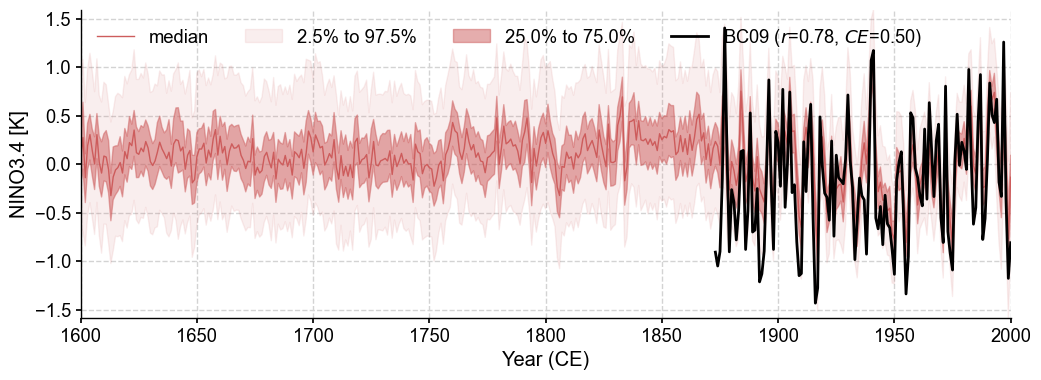

Figure saved at: "results/lmr-pages2k-iCESM-dOTC/corr_recon_BC09.pdf"


In [22]:
fig, ax = res.recons['nino3.4'].validate(ref_time, ref_value, ref_name).plot_qs()
ax.set_xlim(1600, 2000)
ax.set_ylabel('NINO3.4 [K]')
cfr.showfig(fig)
cfr.savefig(fig, './results/lmr-pages2k-iCESM-dOTC/corr_recon_BC09.pdf')

In [22]:
import xarray as xr
ds = xr.open_dataset('./data/tas_sfc_Amon_20CR_185101-201112.nc')
ref_fd = cfr.ClimateField().from_da(da=ds['tas'])

In [30]:
ref_fd_ann = ref_fd.get_anom(ref_period=[1951, 1980]).annualize(months=[12, 1, 2])

In [34]:
ref_fd_ann.da

<xarray.DataArray 'tas' (time: 162, lat: 91, lon: 180)>
array([[[ 7.1690369e-01,  7.1690369e-01,  7.1690369e-01, ...,
          7.1690369e-01,  7.1690369e-01,  7.1690369e-01],
        [ 2.1503525e+00,  2.2120514e+00,  2.2679214e+00, ...,
          1.9588776e+00,  2.0245361e+00,  2.0886612e+00],
        [ 3.3581619e+00,  3.5077972e+00,  3.6580200e+00, ...,
          2.8810577e+00,  3.0441284e+00,  3.2046814e+00],
        ...,
        [-2.5335846e+00, -2.5581741e+00, -2.5896301e+00, ...,
         -2.4542542e+00, -2.4814224e+00, -2.5090103e+00],
        [-2.7338181e+00, -2.7434692e+00, -2.7536087e+00, ...,
         -2.7088242e+00, -2.7198486e+00, -2.7293015e+00],
        [-2.5562592e+00, -2.5562592e+00, -2.5562592e+00, ...,
         -2.5562592e+00, -2.5562592e+00, -2.5562592e+00]],

       [[-3.0655415e+00, -3.0655415e+00, -3.0655415e+00, ...,
         -3.0655415e+00, -3.0655415e+00, -3.0655415e+00],
        [-2.8594921e+00, -2.8558757e+00, -2.8606415e+00, ...,
         -2.8627167e+00, -2.8661449e+00, -2.8624775e+00],
        [-2.4746449e+00, -2.4591777e+00, -2.4497173e+00, ...,
         -2.5207012e+00, -2.5011952e+00, -2.4882710e+00],
...
        [ 2.7984619e-02,  4.6620686e-02,  6.0612995e-02, ...,
         -2.7104696e-02, -8.6263018e-03,  6.4849854e-03],
        [ 2.0793152e-01,  2.1215820e-01,  2.2059123e-01, ...,
          1.7850749e-01,  1.8646748e-01,  1.9814555e-01],
        [-1.5599568e-01, -1.5599568e-01, -1.5599568e-01, ...,
         -1.5599568e-01, -1.5599568e-01, -1.5599568e-01]],

       [[ 7.5868530e+00,  7.5868530e+00,  7.5868530e+00, ...,
          7.5868530e+00,  7.5868530e+00,  7.5868530e+00],
        [ 6.0601959e+00,  6.0754242e+00,  6.1032867e+00, ...,
          5.9857178e+00,  6.0076447e+00,  6.0339203e+00],
        [ 3.4533081e+00,  3.5451508e+00,  3.6359253e+00, ...,
          3.2262268e+00,  3.2963715e+00,  3.3673859e+00],
        ...,
        [-4.3894653e+00, -4.4257355e+00, -4.4487305e+00, ...,
         -4.2693329e+00, -4.3131714e+00, -4.3542023e+00],
        [-3.4067535e+00, -3.4344177e+00, -3.4751892e+00, ...,
         -3.2930908e+00, -3.3261566e+00, -3.3700714e+00],
        [-2.6226349e+00, -2.6226349e+00, -2.6226349e+00, ...,
         -2.6226349e+00, -2.6226349e+00, -2.6226349e+00]]], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1851-02-28 1852-02-29 ... 2012-02-29
  * lat      (lat) float32 90.0 88.0 86.0 84.0 82.0 ... -84.0 -86.0 -88.0 -90.0
  * lon      (lon) float32 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0

/Users/fzhu/Apps/miniconda3/envs/cfr-env/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning:

Degrees of freedom <= 0 for slice.

/Users/fzhu/Apps/miniconda3/envs/cfr-env/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning:

Degrees of freedom <= 0 for slice.

/Users/fzhu/Apps/miniconda3/envs/cfr-env/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:872: UserWarning:

Attempting to set identical left == right == -180.0 results in singular transformations; automatically expanding.



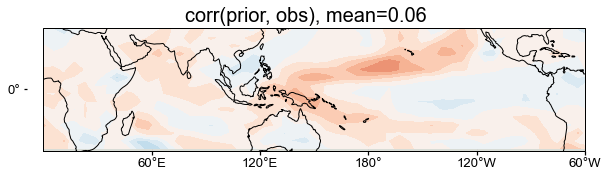

Figure saved at: "results/lmr-real-pages2k/corr_prior_obs.pdf"


In [88]:
stat = 'corr'
valid_fd = job.prior['tas'].validate(
    ref_fd_ann, stat=stat,
    interp_direction='from-ref',
    valid_period=(1874, 2000),
    time_name='time',
)

valid_fd.plot_kwargs.update({'cbar_orientation': 'horizontal', 'cbar_pad': 0.1})
fig, ax = valid_fd.plot(
    title=f'{stat}(prior, obs), mean={valid_fd.geo_mean().values[0]:.2f}',
    projection='PlateCarree',
    latlon_range=(-34, 34, 0, 360),
    plot_cbar=False,
    **valid_fd.plot_kwargs)

cfr.showfig(fig)
cfr.savefig(fig, './results/lmr-real-pages2k/corr_prior_obs.pdf')

/Users/fzhu/Apps/miniconda3/envs/cfr-env/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning:

Degrees of freedom <= 0 for slice.

/Users/fzhu/Apps/miniconda3/envs/cfr-env/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning:

Degrees of freedom <= 0 for slice.

/Users/fzhu/Apps/miniconda3/envs/cfr-env/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:872: UserWarning:

Attempting to set identical left == right == -180.0 results in singular transformations; automatically expanding.



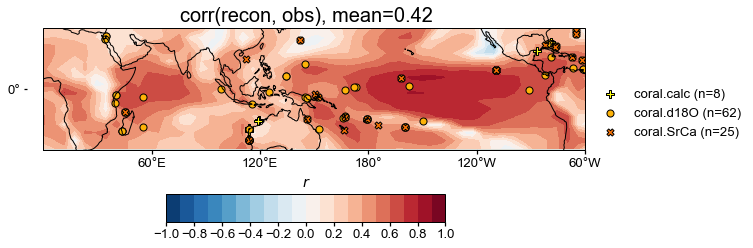

Figure saved at: "results/lmr-real-pages2k/corr_recon_obs.pdf"


In [84]:
stat = 'corr'
valid_fd = res.recons['tas'].validate(
    ref_fd_ann, stat=stat,
    valid_period=(1874, 2000),
    interp_direction='from-ref',
    time_name='time',
)
valid_fd.plot_kwargs.update({'cbar_orientation': 'horizontal', 'cbar_pad': 0.1})

fig, ax = valid_fd.plot(
    title=f'{stat}(recon, obs), mean={valid_fd.geo_mean().values[0]:.2f}',
    projection='PlateCarree',
    latlon_range=(-34, 34, 0, 360),
    plot_proxydb=True, proxydb=job.proxydb.filter(by='tag', keys=['calibrated']),
    proxydb_lgd_kws={'loc': 'lower left', 'bbox_to_anchor': (1, 0)},
    **valid_fd.plot_kwargs)

cfr.showfig(fig)
cfr.savefig(fig, './results/lmr-real-pages2k/corr_recon_obs.pdf')

## Validate the reconstructed NINO3.4

In [26]:
da = job.obs['tas'].annualize().da
da = cfr.utils.geo_mean(da, lat_min=-5, lat_max=5, lon_min=np.mod(-170, 360), lon_max=np.mod(-120, 360))
ref_time = [t for t in da.year]
ref_value = da.values
ref_name = 'truth'

(1000.0, 2000.0)

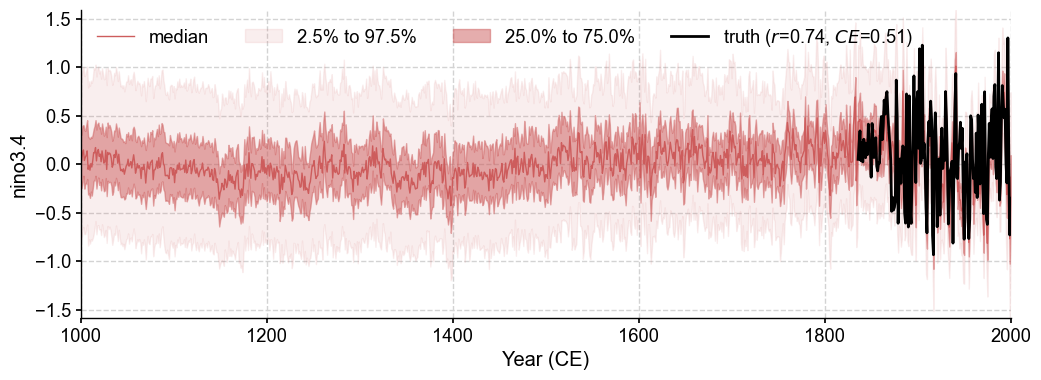

In [28]:
fig, ax = res.recons['nino3.4'].validate(ref_time, ref_value, ref_name).plot_qs()
ax.set_xlim(1000, 2000)


## Validated the reconstructed fields (tas & pr)

In [23]:
# Preparations to add markers representing the sites on the map

lats, lons, colors, markers, markersizes = {}, {}, {}, {}, {}
for pid, pobj in job.proxydb.filter(by='tag', keys=['calibrated']).records.items():
    lats[pid] = pobj.lat
    lons[pid] = pobj.lon
    colors[pid] = cfr.visual.STYLE.colors_dict[pobj.ptype]
    markers[pid] = cfr.visual.STYLE.markers_dict[pobj.ptype]
    markersizes[pid] = 50

/Users/fengzhu/Apps/miniconda3/envs/cfr-env/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1700: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  result = super().scatter(*args, **kwargs)


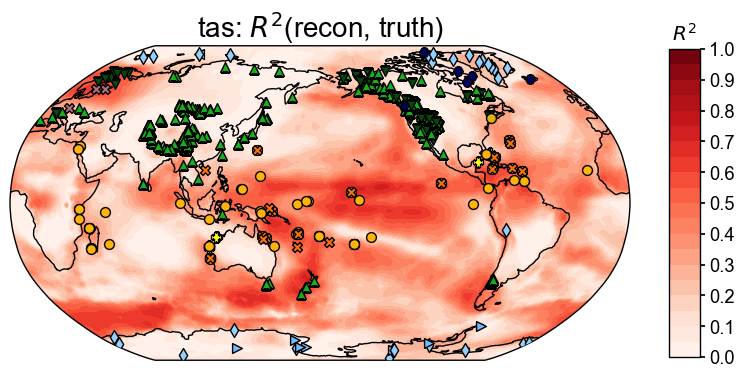

In [24]:
stat = 'R2'
valid_fd = res.recons['tas'].validate(
    job.obs['tas'].annualize(), stat=stat,
    valid_period=(1900, 2000),
    interp_direction='to-ref',
)
fig, ax = valid_fd.plot(
    title=fr'tas: $R^2$(recon, truth)',
    # projection='PlateCarree',
    # latlon_range=(-18, 18, 152, 248),
    add_cyclic_point=True,
    site_lats=lats, site_lons=lons,
    site_markersize=markersizes, site_marker=markers,
    site_color=colors, cbar_title_y=1,
    **valid_fd.plot_kwargs)

/Users/fengzhu/Apps/miniconda3/envs/cfr-env/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1700: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  result = super().scatter(*args, **kwargs)


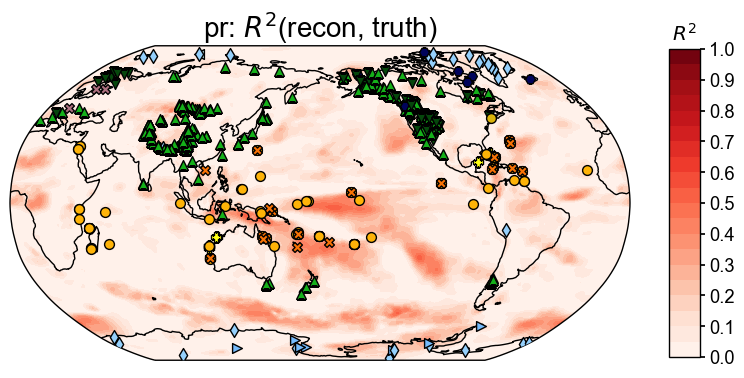

In [25]:
stat = 'R2'
valid_fd = res.recons['pr'].validate(
    job.obs['pr'].annualize(), stat=stat,
    valid_period=(1900, 2000),
    interp_direction='to-ref',
)
fig, ax = valid_fd.plot(
    title=fr'pr: $R^2$(recon, truth)',
    # projection='PlateCarree',
    # latlon_range=(-18, 18, 152, 248),
    add_cyclic_point=True,
    site_lats=lats, site_lons=lons,
    site_markersize=markersizes, site_marker=markers,
    site_color=colors, cbar_title_y=1,
    **valid_fd.plot_kwargs)